# Jupyter with PostgreSQL

## Libararies and Settings

In [315]:
# Libraries
import os
import re
import json
import folium
import urllib
import requests
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import scipy.stats as stats
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(os.getcwd())

/


# Data preparation

## Read data

In [316]:
df = pd.read_csv('/workspace/Tutti.csv', sep=',')
df.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-
2,1703597180-3,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Thurgau, 8370, 26.06.2018, auf autoscout24.ch",LANCIA Dedra 2.0 HF Integrale,6'950.-
3,1703597180-4,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 3604, 04.06.2018, auf autoscout24.ch",LANCIA BETA 2000 Spider,19'990.-
4,1703597180-5,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 4943, 04.04.2018, auf autoscout24.ch",VW Polo 1300 C (X),12'900.-


## Count number of rows and columns in the data frame

In [317]:
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (2804, 5)
Number of rows: 2804
Number of columns: 5


## Extract and save relevant information from raw data using regular expressions (regex)

### Extract Canton

In [318]:
# Extract the first word before the comma in the strings of the 'location_date' column
cantons = []
for i in df['location_date']:
    split_string = i.split(',')[0].strip()  # Splits the string at the comma and takes the first part
    cantons.append(split_string)

# Safe as new variable
df['canton'] = cantons

print(df['location_date'].head(5), '\n')
print(df['canton'].head(5))

0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0      Waadt
1     Aargau
2    Thurgau
3       Bern
4       Bern
Name: canton, dtype: object


### Extract zip_code

In [319]:

# Extract the zip_code that comes after the first and before the second decimal point
zip_code_list = []
for i in df['location_date']:
    parts = i.split(',')
    try:
        zip_code = parts[1].strip()  # Select the second part after the split that contains the zip_code
    except IndexError:
        zip_code = None  # If less than two commas
    zip_code_list.append(zip_code)

# Safe as new variable
df['zip_code'] = zip_code_list

df = df[df['zip_code'].apply(lambda x: len(str(x)) == 4)]

try:
    df['zip_code'] = df['zip_code'].astype('int64')
except ValueError:
    print("Conversion failed: The column contains invalid or missing values.")


print(df['location_date'].head(5), '\n')
print(df['zip_code'].head(5))


0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0    1026
1    5054
2    8370
3    3604
4    4943
Name: zip_code, dtype: int64


### Remove .- in the price and set the type to float

In [320]:
df['price'] = df['price'].str.replace("'", "")  # Removes apostrophe

# Can only be executed once, as the type can only be changed once! Otherwise it requires a new "Execute all".
df['price'] = df['price'].replace({r'\.-$': ''}, regex=True).astype(float) 
df['price'].head()

0     3900.0
1     5990.0
2     6950.0
3    19990.0
4    12900.0
Name: price, dtype: float64

## Count and identify missing values (if any)

In [321]:
# Count missing values
print(pd.isna(df).sum())

# Identify rows with missing values
df[df.isna().any(axis=1)].head()

web-scraper-order        0
web-scraper-start-url    0
location_date            0
brand_type               0
price                    0
canton                   0
zip_code                 0
dtype: int64


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,zip_code


### Count and identify dublicates

In [322]:
# Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
df[df[['web-scraper-order', 'location_date', 'brand_type']].duplicated()]

0


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,zip_code


In [323]:
# Geocoded data (i.e. data with latitude and longitude)
df_geo = pd.read_csv('/workspace/PLZ_Ortschaft_BFSNummer.csv', 
                     sep=';', 
                     encoding='utf-8')

# Rename columns
df_geo = df_geo.rename(columns={'Gemeindename':'place',
                                'BFS-Nr':'bfs_number', 
                                'PLZ':'zip_code'})

# Show data
df_geo[['place', 
        'bfs_number', 
        'zip_code']].head()

,place,bfs_number,zip_code
0,Aeugst am Albis,1,8914
1,Aeugst am Albis,1,8914
2,Affoltern am Albis,2,8909
3,Affoltern am Albis,2,8910
4,Bonstetten,3,8906


### Join informations

In [324]:
# Remove duplicates in df_geo based on 'zip_code', keeping only the first entry
df_geo_unique = df_geo.drop_duplicates(subset='zip_code', keep='first')

# Merge df with df_geo_unique
df2 = df.merge(df_geo_unique[['place', 'bfs_number', 'zip_code']], on='zip_code')

df2.head()


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,zip_code,place,bfs_number
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275
2,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275
3,1703597214-95,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.03.2022, auf Autoscout24.ch",ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275
4,1703597226-129,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.07.2022, auf Autoscout24.ch",CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275


## Add municipalities

In [325]:
df_municip = pd.read_excel('/workspace/municipality_data (1).xlsx', 
                           sheet_name='data_for_import')
df_municip.head(5)

,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,1,Aeugst am Albis,1981,250.442478,14.184755,442.0,105013.570634
1,2,Affoltern am Albis,12303,1161.756374,28.700317,6920.0,71059.805603
2,3,Bonstetten,5572,749.932705,16.564968,1014.0,88927.698145
3,4,Hausen am Albis,3751,275.808824,16.022394,1021.0,86300.455137
4,5,Hedingen,3778,578.560490,16.410799,1478.0,90811.205330


In [326]:
# Merge needs a key which must be identical in both data sets (here the key is 'bfs_number')
df3 = df2.merge(df_municip[['bfs_number', 
                            'pop', 
                            'pop_dens', 
                            'frg_pct', 
                            'emp',
                            'mean_taxable_income']], 
                on="bfs_number")
df3.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,1703597214-95,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.03.2022, auf Autoscout24.ch",ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,1703597226-129,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.07.2022, auf Autoscout24.ch",CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Calculate some mean Prices for Car Types

In [327]:
# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df3[['brand_type', 'price']],
               index=['brand_type'],
               values=['price', 'brand_type'],
               aggfunc=(np.mean))

,price
brand_type,
"'53 Mercury, '60 Pontiac, '79 Chevy in blocco o singole",50000.0
"'72 Ford Ranchero 500 ""survivor""",28500.0
'91 Pontiac TransAm T.-Top option WS6 expertisée du jour,7900.0
** Ford Fiesta 1.3i / 60'000 km !!**,6900.0
** Mercedes-Benz 250 ** Veteran,19900.0
...,...
zu verkaufen,37250.0
zu verkaufen Oldtimer Triumph Spitfire IV Gabriolet,19800.0
zuverkaufen top zustand 2700 fr km 86000,2200.0


In [328]:
df4 = df3.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'location_date'])
df4.head(5)

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Removal of not used webscraper data

In [329]:
df4 = df3.drop(columns=['web-scraper-order','web-scraper-start-url','location_date'])

df4.head(5)

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


## Create database connection

In [330]:
conn = psycopg2.connect("host=localhost dbname=app user=app_user password=app_password")

## Write data to database

In [331]:
engine = create_engine('postgresql://app_user:app_password@db:5432/app')
df4.to_sql('car_table', engine, if_exists='replace')

734

### Removes empty entries in mean_taxable_income

In [332]:
# DELETE-Query
delete_query = text('DELETE FROM car_table WHERE mean_taxable_income IS NULL')

# Run the query
with engine.begin() as conn:
    conn.execute(delete_query)

## SQL query - Read data

In [333]:
df_sub = pd.read_sql_query('''SELECT
                            brand_type,
                            price,
                            canton,
                            zip_code,
                            place,
                            bfs_number,
                            pop,
                            pop_dens,
                            frg_pct,
                            emp,
                            mean_taxable_income
                            FROM car_table''', 
                            con=engine)
df_sub.head()

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


# 4 Non-graphical and graphical exploratory data analysis (EDA)

### Importing the enriched oldtimer data

In [334]:
# Remove duplicates
df_sub = df_sub.drop_duplicates()
df_sub.head(5)

# Remove missing values
df_sub = df_sub.dropna()
df_sub.head(5)

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Quantiles original values

In [335]:
df_sub[['price', 'pop_dens']].quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).round(2)

,price,pop_dens
0.05,2000.0,57.64
0.10,3500.0,96.54
0.25,6900.0,173.60
0.50,14599.5,448.61
0.75,24875.0,1030.37
0.90,39250.0,1915.76
0.95,58000.0,2851.44
0.99,100000.0,4778.99


### Filter oldtimers

In [336]:
df_filtered = df_sub.loc[df_sub['pop_dens'] <= 5000]

df_filtered.head()

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Remove Index

In [337]:
df_filtered=df_filtered.reset_index(drop=True)

### Shape (number of rows and colums)

In [338]:
print(df_filtered.shape)

(2624, 11)


### Data types

In [339]:
df_filtered.dtypes

brand_type              object
price                  float64
canton                  object
zip_code                 int64
place                   object
bfs_number               int64
pop                      int64
pop_dens               float64
frg_pct                float64
emp                    float64
mean_taxable_income    float64
dtype: object

### Summary statistics of numeric variables

In [340]:
df_filtered.describe()

,price,zip_code,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
count,2624.000000,2624.000000,2624.00000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000
mean,19480.919588,6188.266006,2577.48628,19460.456555,774.168811,21.100628,18021.292683,72954.521336
std,20225.867640,2384.947397,1957.98792,58272.867633,912.737481,9.900443,68127.407763,19573.988894
min,100.000000,1000.000000,1.00000,161.000000,2.606078,1.647446,20.000000,42230.717300
25%,6900.000000,4410.000000,608.00000,2194.000000,171.874898,13.475919,780.250000,63569.927536
50%,14600.000000,6417.000000,2556.00000,4971.000000,439.967105,20.029587,2116.000000,68464.601333
75%,24800.000000,8380.500000,4197.50000,12908.250000,1009.259259,27.023443,6871.000000,76953.437739
max,180000.000000,9657.000000,6809.00000,420217.000000,4778.994655,50.269374,491193.000000,229181.911653


### Summary statistics of numeric variables without outliers

In [341]:
# Define the criteria for filtering
min_price = 100
max_price = 125000

# Create a subset of the DataFrame without outliers
filtered_df = df_filtered.loc[
    (df_filtered['price'] >= min_price) & (df_filtered['price'] <= max_price)
]

# Display the first few rows of the filtered DataFrame
filtered_df.describe()

,price,zip_code,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
count,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000
mean,18858.397014,6185.513783,2577.890888,19499.702527,771.660180,21.082794,18071.814319,72859.876461
std,18017.138765,2385.805848,1958.137053,58400.498340,911.371848,9.913398,68277.087657,19393.510467
min,100.000000,1000.000000,1.000000,161.000000,2.606078,1.647446,20.000000,42230.717300
25%,6900.000000,4410.000000,608.000000,2194.000000,168.263800,13.379310,775.000000,63488.370188
50%,14500.000000,6417.000000,2563.500000,4925.000000,436.513158,19.978461,2114.000000,68356.142765
75%,24500.000000,8370.000000,4199.250000,12908.250000,1009.259259,26.895226,6871.000000,76953.437739
max,125000.000000,9657.000000,6809.000000,420217.000000,4778.994655,50.269374,491193.000000,229181.911653


### Statistical measures (min, max, std, mean, median, count) for price

In [342]:
print('Price:',
      'Count:', round(df_filtered.price.count(), 1),
      'Min:', round(df_filtered.price.min(), 1),
      'Max:', round(df_filtered.price.max(), 1),
      'Mean:', round(df_filtered.price.mean(), 1),
      'Median:', round(df_filtered.price.median(), 1),
      'Std:', round(df_filtered.price.std(), 1))

Price: Count: 2624 Min: 100.0 Max: 180000.0 Mean: 19480.9 Median: 14600.0 Std: 20225.9


### Skewness

In [343]:
df_filtered['price'].skew()

3.0314503928315144

### Kurtosis

In [344]:
df_filtered['price'].kurtosis()

13.479398235328823

### Extreme values

In [345]:
# Low costs oldtimers
df_filtered[df_filtered['price'] <= 200]

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
1589,De Tomaso Mangusta,150.0,Zürich,8803,Kilchberg (ZH),135,8923,3458.527132,32.858904,4127.0,166467.202970
1590,Ferrari 512 S,150.0,Zürich,8803,Kilchberg (ZH),135,8923,3458.527132,32.858904,4127.0,166467.202970
1606,"VOLVO 850 (1st Gen.) SCHLACHTFEST, TEILE, PEZZI",100.0,Tessin,6516,Locarno,5113,15776,844.087747,34.248225,13188.0,58270.380018


In [346]:
# Very expensive oldtimers
df_filtered[df_filtered['price'] >= 150000]

,brand_type,price,canton,zip_code,place,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
379,Lancia Aurelia B20 GT,175000.0,Graubünden,7000,Chur,3901,37082,683.665192,20.298258,33020.0,70203.129376
648,PORSCHE 911 930 3.3 Turbo,178000.0,Zürich,8800,Thalwil,141,18139,3298.000000,29.031369,6582.0,106812.909133
1527,VW BUGGY MIRAGE,173000.0,Tessin,6855,Mendrisio,5254,14870,468.051621,21.983860,16431.0,74017.826637
1553,OLDTIMER Alfa romeo 2600 turing,160000.0,Tessin,6982,Agno,5141,4403,1761.200000,32.932092,2772.0,71290.401302
1892,Oldtimer,180000.0,Zürich,8703,Erlenbach (ZH),151,5592,1934.948097,22.961373,1934.0,185490.224981
2104,Original Shelby GT500,150000.0,Freiburg,3215,Murten,2275,8259,334.372470,20.038746,4738.0,72068.317853
2621,CHEVROLET Impala V8 Sport Coupé Ab Veteran MFK...,166000.0,Aargau,5436,Würenlos,4048,6494,719.955654,18.247613,2254.0,87427.654947


### Get a list of categories of categorical variable

In [347]:
np.array(pd.Categorical(df_filtered['place']).categories)

array(['Aadorf', 'Aarau', 'Aarberg', 'Aarburg', 'Aarwangen', 'Adelboden',
       'Adligenswil', 'Aegerten', 'Aesch (BL)', 'Aesch (LU)',
       'Aesch (ZH)', 'Aeugst am Albis', 'Affeltrangen',
       'Affoltern am Albis', 'Agarn', 'Agno', 'Aigle', 'Airolo',
       'Albula/Alvra', 'Allschwil', 'Alpnach', 'Alpthal', 'Altdorf (UR)',
       'Altendorf', 'Altishofen', 'Altnau', 'Alto Malcantone',
       'Altstätten', 'Amden', 'Ammerswil', 'Appenzell', 'Arboldswil',
       'Arbon', 'Arch', 'Aristau', 'Arlesheim', 'Arni (AG)', 'Arni (BE)',
       'Arth', 'Ascona', 'Astano', 'Attalens', 'Attinghausen', 'Au (SG)',
       'Aubonne', 'Auenstein', 'Augst', 'Ausserberg', 'Auw', 'Avully',
       'Ayent', 'Baar', 'Bachenbülach', 'Bachs', 'Bad Ragaz', 'Baden',
       'Balerna', 'Balgach', 'Ballwil', 'Balm bei Günsberg',
       'Baltschieder', 'Bannwil', 'Bardonnex', 'Bargen (SH)',
       'Basadingen-Schlattingen', 'Bassersdorf', 'Baulmes', 'Beatenberg',
       'Beckenried', 'Beinwil am See', 'Bellach',

## Multivariate non-graphical exploratory data analysis (EDA)

### Correlation matrix

In [348]:
corr = df_filtered[['price', 'pop_dens', 'frg_pct']].cov().corr()
corr

,price,pop_dens,frg_pct
price,1.000000,0.443418,0.088360
pop_dens,0.443418,1.000000,0.931989
frg_pct,0.088360,0.931989,1.000000


### Covariance matrix

In [349]:
cov = df_filtered[['price', 'pop_dens', 'frg_pct']].cov()
cov

,price,pop_dens,frg_pct
price,4.090857e+08,772375.446236,2948.410543
pop_dens,7.723754e+05,833089.708967,5051.782434
frg_pct,2.948411e+03,5051.782434,98.018781


In [350]:
print(df_filtered.columns)

Index(['brand_type', 'price', 'canton', 'zip_code', 'place', 'bfs_number',
       'pop', 'pop_dens', 'frg_pct', 'emp', 'mean_taxable_income'],
      dtype='object')


## Univariate graphical exploratory data analysis (EDA)

### Boxplot (seaborn)

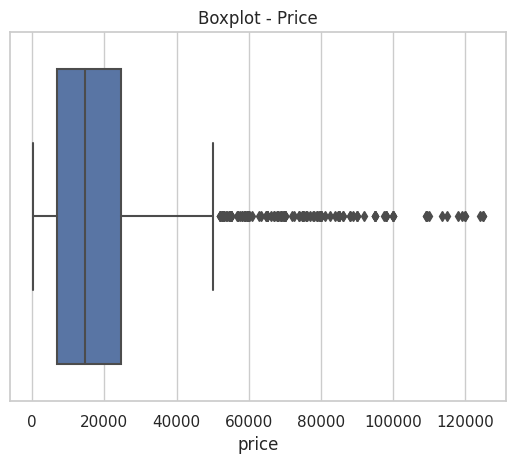

In [351]:
sns.boxplot(x=filtered_df['price'])
plt.title('Boxplot - Price')
plt.show()

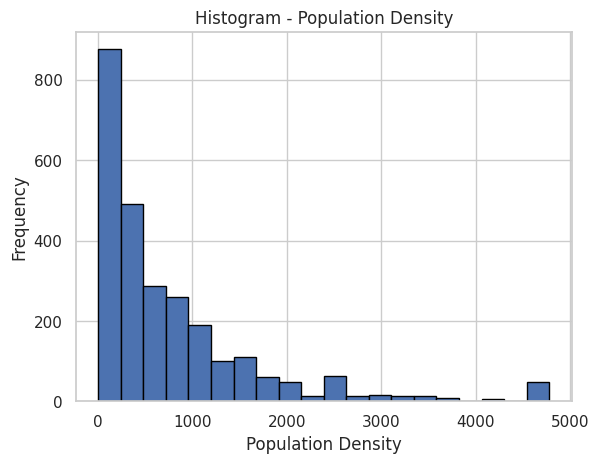

In [352]:
plt.hist(filtered_df['pop_dens'], bins=20, edgecolor='black')
plt.title('Histogram - Population Density')
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.show()

### Density plot  (seaborn)

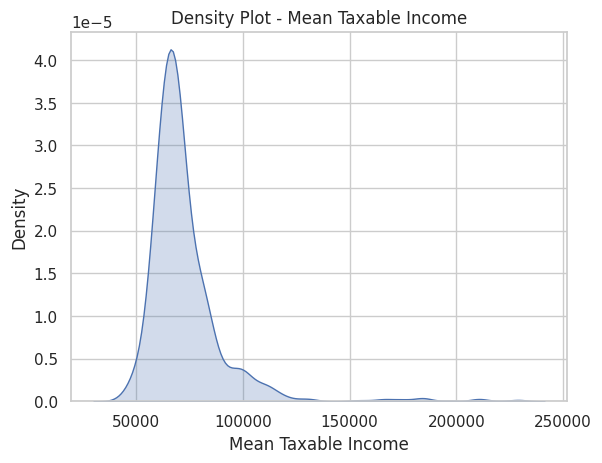

In [353]:
sns.kdeplot(filtered_df['mean_taxable_income'], fill=True)
plt.title('Density Plot - Mean Taxable Income')
plt.xlabel('Mean Taxable Income')
plt.ylabel('Density')
plt.show()

### Quantile-Quantile (QQ-) plot

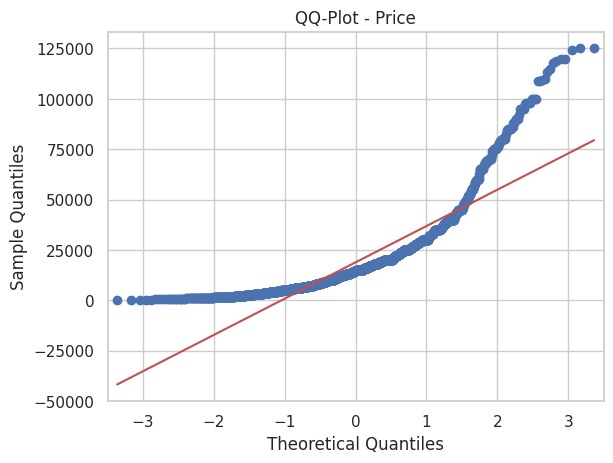

In [354]:
sm.qqplot(filtered_df['price'], line='s')
plt.title('QQ-Plot - Price')
plt.show()

## Multivariate graphical exploratory data analysis (EDA)

### Scatter plot popdens_price

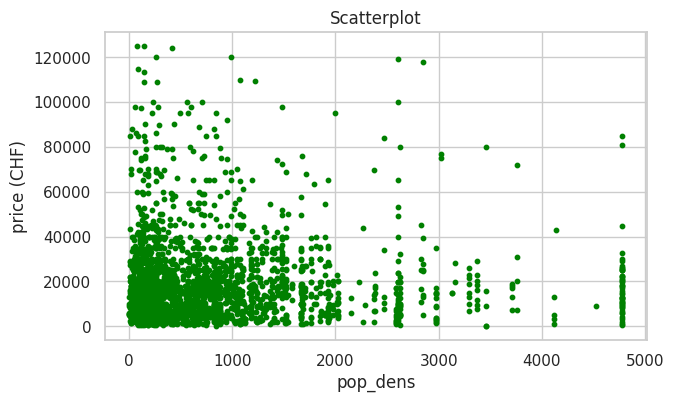

In [355]:
plt.figure(figsize=(7,4))
plt.scatter(filtered_df['pop_dens'], 
           filtered_df['price'], 
           color="green", 
           alpha=1.0,
           s=10)
plt.title('Scatterplot', fontsize=12)
plt.xlabel('pop_dens')
plt.ylabel('price (CHF)')
plt.show()


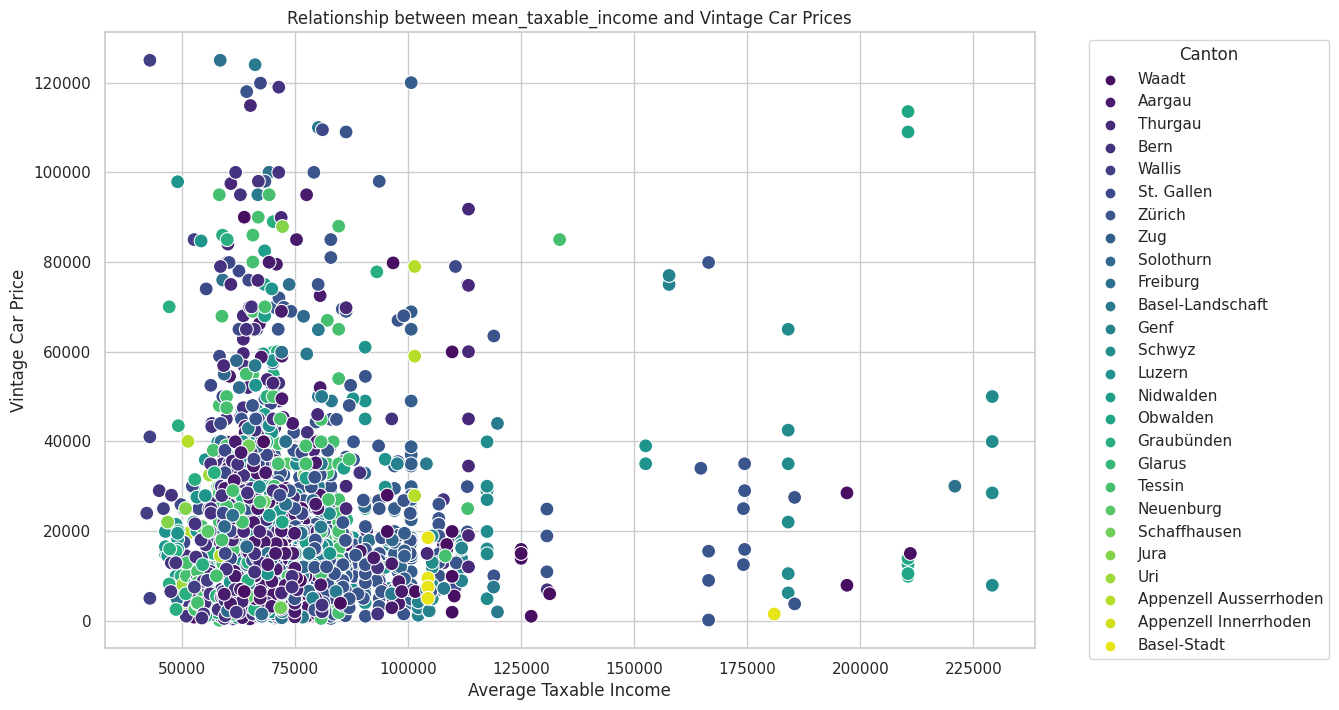

In [356]:
# Prepare data
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create scatter plot
scatterplot = sns.scatterplot(x='mean_taxable_income', y='price', data=filtered_df, hue='canton', palette='viridis', s=100)

# Adjust the plot
scatterplot.set_title('Relationship between mean_taxable_income and Vintage Car Prices')
scatterplot.set_xlabel('Average Taxable Income')
scatterplot.set_ylabel('Vintage Car Price')

# Add legend
plt.legend(title='Canton', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


# 5 - Regression for the modeling method

### Create train and test samples (train = 80%, test = 20% of the data)

In [357]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_filtered['zip_code'], 
                                                    df_filtered['price'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
2535    1053
1435    8212
482     6850
695     2558
438     5502
Name: zip_code, dtype: int64 

y_train:
2535     3900.0
1435     4999.0
482     10000.0
695     16900.0
438      1990.0
Name: price, dtype: float64


In [358]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            16060.09
Slope of regression line (beta):          0.589
p-value:                                  0.0022
R-squared (coefficient of determination): 0.0045


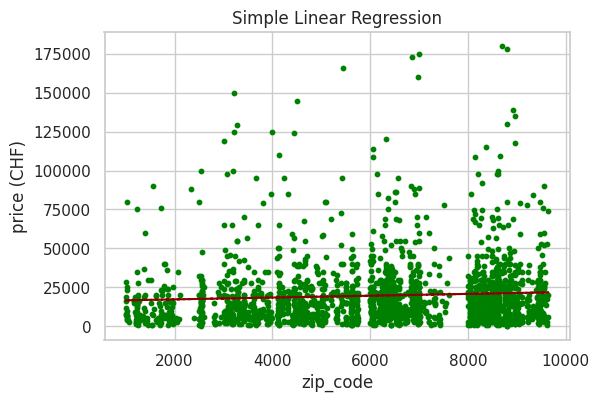

In [359]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('zip_code')
plt.ylabel('price (CHF)')

plt.show()

### Check model residuals (residuals = observed prices minus predicted prices)

In [360]:
# Calculate model residuals for train data
residuals = y_train - mymodel

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel[0]:.2f}')
print(f'1st Observed price in dataset: {y_train[0]:.2f}')
print(f'1st Residual price in dataset: {residuals[0]:.2f}')

1st Predicted price in dataset: 16680.36
1st Observed price in dataset: 3900.00
1st Residual price in dataset: -12780.36


### Plot histogram of residuals

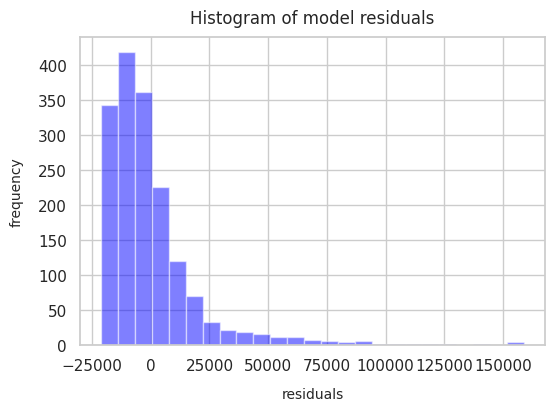

In [361]:
# Plot histogram of residuals
fig = plt.figure( figsize=(6,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

### Compare the observed prices with the predicted prices

In [362]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)
#print(predicted)
# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed price: {y_test.iloc[i]:.1f}, Predicted price: {predicted.iloc[i]:.1f}')

Observed price: 14900.0, Predicted price: 20954.5
Observed price: 6500.0, Predicted price: 21134.8
Observed price: 18500.0, Predicted price: 19843.6
Observed price: 2000.0, Predicted price: 18946.5
Observed price: 8500.0, Predicted price: 20314.2
Observed price: 1500.0, Predicted price: 20862.6
Observed price: 15000.0, Predicted price: 20869.1
Observed price: 6999.0, Predicted price: 17161.6
Observed price: 29800.0, Predicted price: 19779.4
Observed price: 6999.0, Predicted price: 21243.8


## Multiple linear regression

### Create train and test samples (train = 80%, test = 20% of the data)

In [363]:
# Create train and test samples (we name it X2_ and y_2 because we already used X_ and y_ above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df_filtered[['zip_code',
                                                            'pop_dens']], 
                                                        df_filtered['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
      zip_code     pop_dens
2535      1053   301.045296
1435      8212   280.414013
482       6850   185.617597
695       2558  1009.259259
438       5502  1238.650307 

y2_train:
2535     3900.0
1435     4999.0
482     10000.0
695     16900.0
438      1990.0
Name: price, dtype: float64


### Fit the multiple regression model

In [364]:
# Add constant to the model
X2_train_const = sm.add_constant(X2_train)

# Create the multiple regression model
olsmod = sm.OLS(y_train, X2_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.024
Date:                Sun, 07 Jan 2024   Prob (F-statistic):            0.00246
Time:                        16:54:36   Log-Likelihood:                -23858.
No. Observations:                2099   AIC:                         4.772e+04
Df Residuals:                    2096   BIC:                         4.774e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.552e+04   1318.069     11.778      0.0

### Plot histogram of residuals

Text(0.5, 1.0, 'Histogram of model residuals')

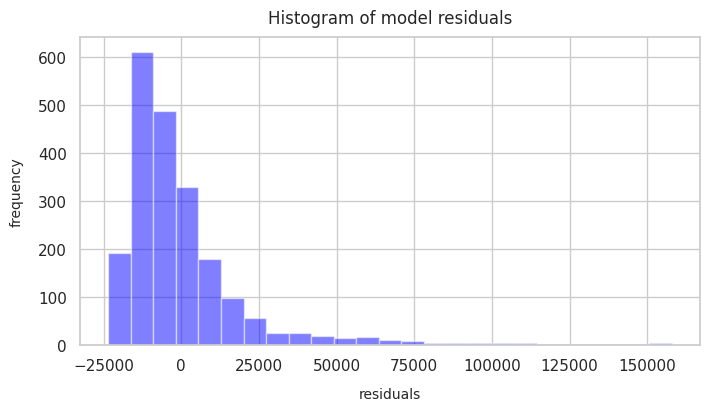

In [365]:
# Plot histogram of residuals
fig = plt.figure( figsize=(8,4))
n, bins, patches = plt.hist(x=olsres.resid, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# 6 - Suitable measures of fit

## Regression Tree

### Create train and test samples for the regression tree (train = 80%, test = 20% of the data)

In [366]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_filtered[['zip_code',
                                                        'pop_dens',
                                                        'pop',
                                                        'mean_taxable_income']], 
                                                        df_filtered['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
      zip_code     pop_dens   pop  mean_taxable_income
2535      1053   301.045296   864         85057.611940
1435      8212   280.414013  1761         93635.799207
482       6850   185.617597  2194         82158.387800
695       2558  1009.259259  2180         61708.165829
438       5502  1238.650307  4038         64482.346431 

y_train:
2535     3900.0
1435     4999.0
482     10000.0
695     16900.0
438      1990.0
Name: price, dtype: float64


### Fit regression tree model

In [367]:
# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=3)

# Train decision tree regressor
reg = reg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = reg.predict(X_test)

### Calculate coefficient of determination (R-squared)

In [368]:
# Calculate coefficient of determination
print('R-squared:', r2_score(y_test, y_pred).round(4))

R-squared: 0.0384


### Print text representation of the regression tree

In [369]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

|--- mean_taxable_income <= 112478.72
|   |--- zip_code <= 2064.00
|   |   |--- pop <= 1005.00
|   |   |   |--- value: [19923.42]
|   |   |--- pop >  1005.00
|   |   |   |--- value: [12481.69]
|   |--- zip_code >  2064.00
|   |   |--- mean_taxable_income <= 65089.62
|   |   |   |--- value: [17482.31]
|   |   |--- mean_taxable_income >  65089.62
|   |   |   |--- value: [20995.03]
|--- mean_taxable_income >  112478.72
|   |--- zip_code <= 6061.00
|   |   |--- pop_dens <= 2644.43
|   |   |   |--- value: [13421.82]
|   |   |--- pop_dens >  2644.43
|   |   |   |--- value: [75000.00]
|   |--- zip_code >  6061.00
|   |   |--- zip_code <= 6935.00
|   |   |   |--- value: [102520.00]
|   |   |--- zip_code >  6935.00
|   |   |   |--- value: [34875.90]



### Vizualizing the regression tree

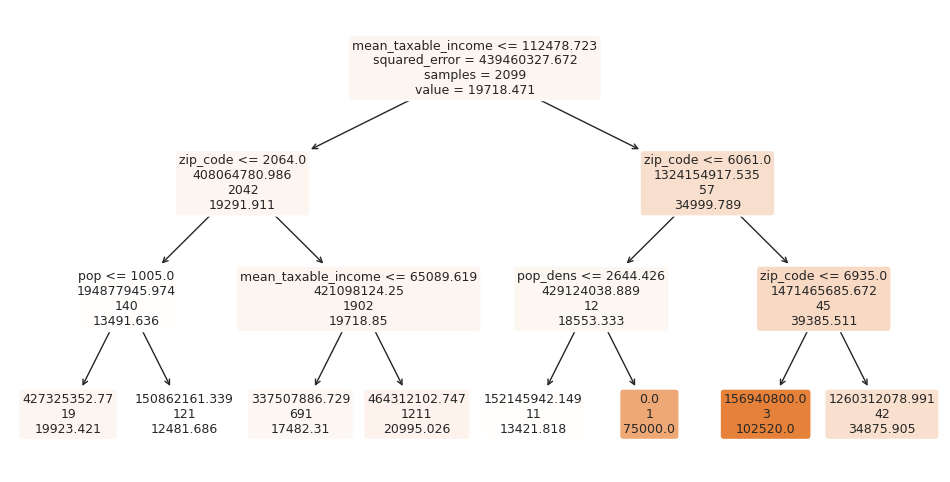

In [370]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=9,
                   label='root',
                   rounded=True)

## Random Forest Regression


### Create train and test samples for the random forest (train = 80%, test = 20% of the data)

In [371]:
# Create train and test samples
X2_train, X2_test, y2_train, y2_test = train_test_split(df_filtered[['zip_code',
                                                        'pop_dens',
                                                        'pop',
                                                        'mean_taxable_income']], 
                                                        df_filtered['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X2_train.head(), '\n')

# Show y_train
print('y_train:')
print(y2_train.head())

X_train:
      zip_code     pop_dens   pop  mean_taxable_income
2535      1053   301.045296   864         85057.611940
1435      8212   280.414013  1761         93635.799207
482       6850   185.617597  2194         82158.387800
695       2558  1009.259259  2180         61708.165829
438       5502  1238.650307  4038         64482.346431 

y_train:
2535     3900.0
1435     4999.0
482     10000.0
695     16900.0
438      1990.0
Name: price, dtype: float64


### Fit the Random Forest Regression

In [372]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X2_test, y2_test).round(4))

R-squared: 0.0159


## Show feature importance

Index(['zip_code', 'mean_taxable_income', 'pop', 'pop_dens'], dtype='object')
[0.33601037 0.28144776 0.19597321 0.18656867]


<Axes: ylabel='features'>

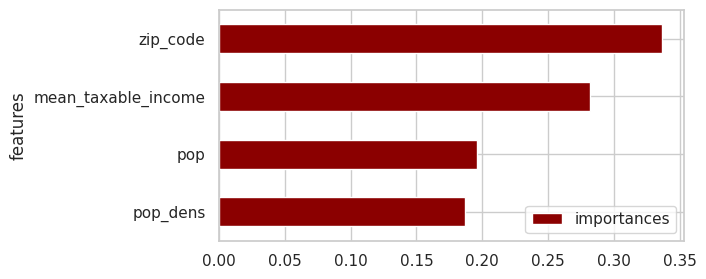

In [373]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))


# Integration and visualization of geographical data

### Geocoding multiple car addresses using the geoadmin API

In [374]:
# Define base url
base_url= "https://api3.geo.admin.ch/rest/services/api/SearchServer?"

# Geocode list of adresses
geolocation = []
n = 1


for index, row in df_filtered.iterrows():
    i = row['zip_code']
    #for i in df_filtered['zip_code'].astype(str):
    
    print('Geocoding address', 
          n, 
          'out of', 
          len(df_filtered['zip_code']), 
          ':', 
          i)
    n=n+1
    clear_output(wait=True)
    
    try:
        # Set up search parameters - address, origins and type
        parameters = {"searchText": i,
                      "origins": "zipcode",
                      "type": "locations",
                     }

        # Server request
        r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")

        # Get data
        data = json.loads(r.content)
            
        # Initialize a variable to store the matching result
        matching_data = None
        df_loc = None
        for result in data["results"]:
            label = result["attrs"]["label"]
            
            place_value = row['place']
            if '(' in place_value and ')' in place_value:
                place_value = re.sub(r'\([^)]*\)', '', place_value)
            if place_value in label:
                matching_data = result  # Store the matching result
                break  # Stop iterating once a match is found

        if matching_data:
            # Take only the first server response, convert to data frame with relevant infos
            attrs_data = matching_data["attrs"]
            # Creating a DataFrame from the attributes data
            df_loc = pd.DataFrame.from_dict([attrs_data], orient='columns')
            if 'lat' in df_loc.columns and 'lon' in df_loc.columns:
                lat = df_loc['lat'].astype(float).values[0]
                lon = df_loc['lon'].astype(float).values[0]
                geolocation.append(pd.Series(data={'lat': lat, 'lon': lon}))
            else:
                print("Latitude or Longitude column missing in df_loc.")

        else:
            # if responding label does not match with place (from the database), then take first api response
            df_loc = pd.DataFrame.from_dict(list(data.values())[0][0], orient='columns')
            geolocation.append(df_loc.iloc[[5,6],0].astype(float))

    except Exception as error:
        print("An exception occurred:", error) 
        geolocation.append(pd.Series(data={'lat': None, 'lon': None}))
        break
        

# Write lat and lon to df
df_loc = pd.DataFrame(geolocation, 
                      columns=("lat", "lon"), 
                      index=range(len(df_filtered['zip_code'])))
df_filtered['lat'] = df_loc['lat']
df_filtered['lon'] = df_loc['lon']

# Writeback to the database
df_filtered.to_sql('car_table', engine, if_exists='replace')



624

### Plot addresses on map

In [375]:
# Initialisation of the Map
m = folium.Map(location=[47.44, 8.65], zoom_start=10)

# Add lat/lon of addresses
df_sub = df_filtered.dropna()

for i in range(0, len(df_sub)):
    lat = df_sub.iloc[i]['lat']
    lon = df_sub.iloc[i]['lon']

    # Read count of same location
    query = '''SELECT count(*) from car_table where lat={lat} AND lon = {lon}'''.format(lat=lat, lon=lon)
    count = pd.read_sql_query(query, con=engine)
    popup_content= f"Amount of cars: {str(count.astype(int).values[0])[1:-1]}"
    folium.Marker(location=(df_sub.iloc[i]['lat'], 
                            df_sub.iloc[i]['lon']), 
                  popup=folium.Popup(popup_content, parse_html=True)).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

# Use of Chi-Squared test

In [376]:
# Create labels
labels = ['0 - 1000', '1001 - 10000', '10001 - 50000', '50001 - 100000', '>= 100001']

# Create new categorical variable
df_filtered["price_cat"] = pd.cut(df_filtered['price'], bins=[0, 1001, 10001, 50001, 100001, 180000], labels=labels)

# Check values
df_filtered[['price', 'price_cat']].head(10)

,price,price_cat
0,3900.0,1001 - 10000
1,5990.0,1001 - 10000
2,5990.0,1001 - 10000
3,6990.0,1001 - 10000
4,4990.0,1001 - 10000
5,3990.0,1001 - 10000
6,24200.0,10001 - 50000
7,13000.0,10001 - 50000
8,6950.0,1001 - 10000
9,4800.0,1001 - 10000


In [377]:
# Contingency table (numbers in the table are apartments)
tab = pd.pivot_table(df_filtered[['price', 'canton', 'price_cat']],
                     index=['canton'],
                     columns=['price_cat'], 
                     aggfunc='count')
tab

price                                            \
price_cat              0 - 1000 1001 - 10000 10001 - 50000 50001 - 100000   
canton                                                                      
Aargau                        6          106           154             11   
Appenzell Ausserrhoden        0            9            16              2   
Appenzell Innerrhoden         0            2             2              0   
Basel-Landschaft              4           36            47              4   
Basel-Stadt                   0            4             1              0   
Bern                          6          128           163             15   
Freiburg                      4           31            29              4   
Genf                          1           21            19              2   
Glarus                        0           10             9              0   
Graubünden                    2           35            40              8   
Jura                          0           10             4              1   
Luzern                        2           43            90              8   
Neuenburg                     0            5             3              0   
Nidwalden                     0            1            11              3   
Obwalden                      1           13            17              0   
Schaffhausen                  0           19            14              1   
Schwyz                        3           18            67              2   
Solothurn                     1           39            71              4   
St. Gallen                    2           73           117             10   
Tessin                        2           73           109             16   
Thurgau                       3           59           112             16   
Uri                           0            1            12              0   
Waadt                         2           30            34              3   
Wallis                        1           33            24              1   
Zug                           0            9            41              3   
Zürich                        6          140           265             20   

                                  
price_cat              >= 100001  
canton                            
Aargau                         2  
Appenzell Ausserrhoden         0  
Appenzell Innerrhoden          0  
Basel-Landschaft               2  
Basel-Stadt                    0  
Bern                           1  
Freiburg                       3  
Genf                           0  
Glarus                         0  
Graubünden                     1  
Jura                           0  
Luzern                         0  
Neuenburg                      0  
Nidwalden                      0  
Obwalden                       2  
Schaffhausen                   0  
Schwyz                         0  
Solothurn                      1  
St. Gallen                     2  
Tessin                         2  
Thurgau                        1  
Uri                            0  
Waadt                          0  
Wallis                         1  
Zug                            1  
Zürich                         6

## Perform a Chi-square test on the cars table

In [378]:
# 1-alpha
prob = 0.95

# Chi-squared test
stat, p, dof, expected = chi2_contingency(tab)

# Critical value
critical = chi2.ppf(prob, dof)

# Print results of the Chi-square test
print('Expected frequencies:', '\n', expected.round(1), '\n')
print('Critical value:', critical.round(4), '\n')
print('Test statistic:', stat.round(4), '\n')
print('Degrees of freedom:', dof, '\n')
print(f'p-value: {p:.4f}')

Expected frequencies: 
 [[4.900e+00 1.008e+02 1.564e+02 1.420e+01 2.700e+00]
 [5.000e-01 9.800e+00 1.510e+01 1.400e+00 3.000e-01]
 [1.000e-01 1.400e+00 2.200e+00 2.000e-01 0.000e+00]
 [1.600e+00 3.360e+01 5.210e+01 4.700e+00 9.000e-01]
 [1.000e-01 1.800e+00 2.800e+00 3.000e-01 0.000e+00]
 [5.500e+00 1.131e+02 1.755e+02 1.600e+01 3.000e+00]
 [1.200e+00 2.570e+01 3.980e+01 3.600e+00 7.000e-01]
 [8.000e-01 1.550e+01 2.410e+01 2.200e+00 4.000e-01]
 [3.000e-01 6.900e+00 1.070e+01 1.000e+00 2.000e-01]
 [1.500e+00 3.110e+01 4.820e+01 4.400e+00 8.000e-01]
 [3.000e-01 5.400e+00 8.400e+00 8.000e-01 1.000e-01]
 [2.500e+00 5.170e+01 8.020e+01 7.300e+00 1.400e+00]
 [1.000e-01 2.900e+00 4.500e+00 4.000e-01 1.000e-01]
 [3.000e-01 5.400e+00 8.400e+00 8.000e-01 1.000e-01]
 [6.000e-01 1.190e+01 1.850e+01 1.700e+00 3.000e-01]
 [6.000e-01 1.230e+01 1.910e+01 1.700e+00 3.000e-01]
 [1.600e+00 3.250e+01 5.050e+01 4.600e+00 9.000e-01]
 [2.000e+00 4.190e+01 6.500e+01 5.900e+00 1.100e+00]
 [3.600e+00 7.370e+01 

# Finding clusters in the oldtimer data

### Subset of the apartment data frame for k-means clustering

In [379]:
# Define a subset of the data frame for k-means clustering
X3 = df_filtered[[
         'price', 
         'pop_dens',
         'lat',
         'lon',]]

### Elbow method showing the optimal k

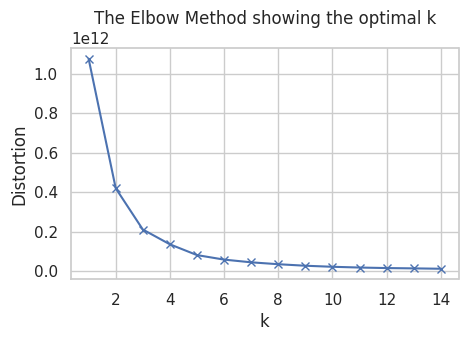

In [380]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X3)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

### Perform k-means clustering on the oldtimer data

In [381]:
# Number of clusters
k = 4

# Perform k-means clustering
kmeans_oldtimer = KMeans(n_clusters=k, random_state=42).fit(X3)

# Add the clusters to data frame
X3['cluster'] = kmeans_oldtimer.predict(X3)

# Show number of apartments per cluster
X3['cluster'].value_counts().sort_values(ascending=False)

cluster
0    1646
1     804
3     149
2      25
Name: count, dtype: int64

### Plot the oldtimer clusters

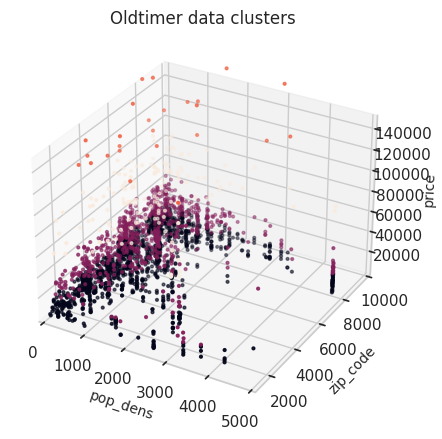

In [382]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_filtered['pop_dens'], df_filtered['zip_code'], df_filtered['price'], c=kmeans_oldtimer.labels_, s=4)

# Set title and axes labels
ax.set_title('Oldtimer data clusters', fontsize=12)
ax.set_xlabel('pop_dens', fontsize=10)
ax.set_ylabel('zip_code', fontsize=10)
ax.set_zlabel('price', fontsize=10)

# Set axes range
ax.set_xlim([0,5000])
ax.set_ylim([1000,10000])
ax.set_zlim([20,150000])

plt.show()

### Print values from 'kmeans_oldtimer'

In [383]:
print(kmeans_oldtimer.labels_, '\n')
print(kmeans_oldtimer.inertia_, '\n')
print(kmeans_oldtimer.cluster_centers_, '\n')
print(kmeans_oldtimer.feature_names_in_)

[0 0 0 ... 2 0 0] 

135919936715.50247 

[[9.08070170e+03 7.58671318e+02 4.70972754e+01 8.25656528e+00]
 [2.79487351e+04 7.87292222e+02 4.71363165e+01 8.41165231e+00]
 [1.35066400e+05 1.04597490e+03 4.70684720e+01 8.30270052e+00]
 [6.92862752e+04 8.28950677e+02 4.70803161e+01 8.44487213e+00]] 

['price' 'pop_dens' 'lat' 'lon']


### Calculate the Silhouette Score

In [384]:
print(f'Silhouette Score: {silhouette_score(X3, kmeans_oldtimer.labels_):.4f}')

Silhouette Score: 0.5846


### Close DB connection

In [385]:
conn.close()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [386]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.2.0-1018-azure
Datetime: 2024-01-07 16:56:24
Python Version: 3.10.12
-----------------------------------
